In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [10]:
INPUT_CSV = "plagiarism_pairs.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [11]:
df = pd.read_csv(INPUT_CSV)
print(f"Datos cargados: {len(df)} pares")

Datos cargados: 1312 pares


In [12]:
# Lista con todos los códigos del csv 
corpus = df['code1'].tolist() + df['code2'].tolist() 

# Configurar el vectorizador que se comporte de la sigueinte forma:
# Ingnorar identificadores de Java para no tomarlos ne cunta -> ',",),(,{,},[,],,,.,;,:,!?,+,-,*,/,%,**,//,==,!=,<,>,<=,>=,&&,||,=,+=,-=,\n,\t,\r,@,#,$,,/,~
# Mantener mayúsculas/minúsculas (importante en Java)
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', lowercase=False)

# Analiza el corpus y crea un diccionario con todas las palabras únicas
vectorizer.fit(corpus)
print("Tamaño del diccionario:", len(vectorizer.vocabulary_))
print("Palabras en el diccionario:", list(vectorizer.vocabulary_.keys()))

# Convierte cada fragmento de código en un vector de números, donde cada número representa qué tan importante es una palabra en ese código
X1 = vectorizer.transform(df['code1'])
X2 = vectorizer.transform(df['code2'])

# Número alto -> Aparece varias veces en ese código y aparece muy poco o nada en los demás códigos
# Número bajo -> Se repite mucho en todos los textos y Casi no aparece en este código
# 0 -> Esa palabra no aparece en ese fragmento

# Diferencia absoluta para capturar similitud entre los 2 códigos
X = sp.csr_matrix(np.abs(X1 - X2))  

# Etiquetas 
y = df['label'].values

Tamaño del diccionario: 2824
Palabras en el diccionario: ['import', 'java', 'io', 'PrintWriter', 'util', 'public', 'class', 'codeforces', 'static', 'int', 'dp', 'new', '5001', 'void', 'main', 'String', 'args', 'Scanner', 's', 'System', 'in', 'out', 't', '1', 'for', 'tt', '0', 'n', 'nextInt', 'a', 'ArrayList', 'Integer', 'z', 'o', 'i', 'if', 'add', 'else', 'Arrays', 'fill', 'println', 'sol', 'close', 'j', 'size', 'return', 'h', 'l', '10000000', 'ans1', 'ans2', 'Math', 'abs', 'get', 'min', 'Soltion', 'sc', 'while', 'arr', 'next', 'List', 'blue', 'red', 'length', 'charAt', 'B', 'Collections', 'sort', 'p', 'q', 'boolean', 'flag', 'true', 'false', 'break', 'Yes', 'No', 'D_Java', 'final', 'MOD', '998244353', 'mul', 'b', 'long', 'f', 'rf', 'C', 'k', 'pow', 'res', 'shuffleArray', 'Random', 'rnd', 'index', 'tmp', 'inv', '2', 'doIt', 'throws', 'IOException', 'BufferedReader', 'InputStreamReader', 'StringTokenizer', 'tok', 'readLine', 'parseInt', 'nextToken', '42', 'events', 'le', 'ri', 'ans', 'b

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [14]:
model = LogisticRegression(max_iter=50, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

LogisticRegression(max_iter=50, random_state=42)


Reporte de clasificación:
              precision    recall  f1-score   support

   No plagio       0.85      0.98      0.91       132
      Plagio       0.97      0.83      0.90       131

    accuracy                           0.90       263
   macro avg       0.91      0.90      0.90       263
weighted avg       0.91      0.90      0.90       263



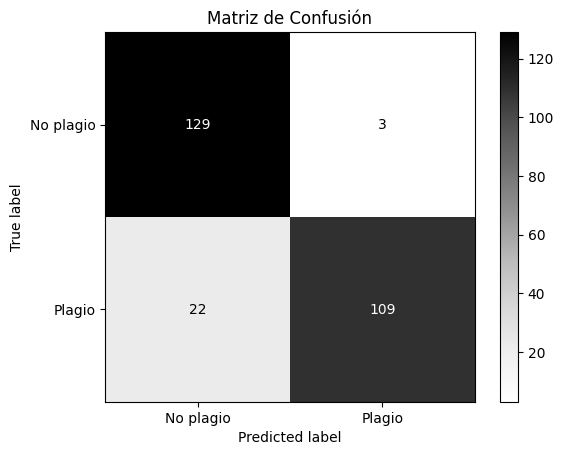

In [15]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No plagio', 'Plagio']))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No plagio', 'Plagio'])
disp.plot(cmap='Grays') 
plt.title('Matriz de Confusión')
plt.show()

## XGBOOST model

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Aumentar peso de la clase "Plagio"
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicciones con umbral ajustado
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.4  # Ajusta si es necesario
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluación
print("\nReporte de clasificación (XGBoost con scale_pos_weight ajustado):")
print(classification_report(y_test, y_pred, target_names=['No plagio', 'Plagio']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No plagio', 'Plagio'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (XGBoost)')
plt.show()

ModuleNotFoundError: No module named 'xgboost'